<a href="https://colab.research.google.com/github/Menon-Vineet/Python-Basics-Simpli-/blob/main/BAMA_517_Final_v2a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns


In [52]:
# Load the Excel file
file_path = '/content/BAMA 517 Final Assignment - Data.xlsx'  # Update with the correct path
sheets = pd.ExcelFile(file_path)

# Function to display headers of each sheet
def display_sheet_headers(sheets):
    """
    Display headers of each sheet in the Excel file.
    """
    for sheet_name in sheets.sheet_names:
        sheet_data = sheets.parse(sheet_name)
        print(f"Header for sheet '{sheet_name}':")
        print(sheet_data.head())  # Display the first few rows of the sheet
        print("\n" + "="*50 + "\n")

# Display headers for each sheet
display_sheet_headers(sheets)


Header for sheet 'Prescription':
   Physician ID  2012-01-06 00:00:00  2012-01-13 00:00:00  \
0           497                 0.00                 1.27   
1           509                 0.00                 0.00   
2           589                 0.00                10.56   
3           595                 2.34                 3.00   
4           619                 1.13                 0.00   

   2012-01-20 00:00:00  2012-01-27 00:00:00  2012-02-03 00:00:00  \
0                 0.00                 1.29                  0.0   
1                 0.00                 0.00                  0.0   
2                 0.00                 0.00                  0.0   
3                 5.05                 0.99                  0.0   
4                 0.00                 1.20                  0.0   

   2012-02-10 00:00:00  2012-02-17 00:00:00  2012-02-24 00:00:00  \
0                 1.05                 2.25                 0.00   
1                 0.00                 1.16            

In [53]:
if 'Geography' in processed_dataframes:
    merged_data = merged_data.merge(processed_dataframes['Geography'], on=['Physician ID', 'Date'], how='left')
if 'Industry Decile Ranking' in processed_dataframes:
    merged_data = merged_data.merge(processed_dataframes['Industry Decile Ranking'], on=['Physician ID', 'Date'], how='left')

In [54]:
# Function to reshape each sheet from wide to long format
def reshape_sheet(sheet, sheet_name):
    """
    Reshape a sheet from wide to long format. Replace NaN values with 0.
    """
    # Replace all NaN values with 0
    sheet.fillna(0, inplace=True)

    # Ensure the first row (except "Physician ID") contains valid dates
    valid_columns = ['Physician ID'] + [
        col for col in sheet.columns[1:] if pd.to_datetime(col, errors='coerce') is not pd.NaT
    ]

    # Reshape the data
    reshaped = sheet[valid_columns].melt(
        id_vars=['Physician ID'],
        var_name='Date',
        value_name=sheet_name
    )
    reshaped['Date'] = pd.to_datetime(reshaped['Date'], errors='coerce')  # Convert Date to datetime
    reshaped.dropna(subset=['Date'], inplace=True)  # Drop rows with invalid dates
    return reshaped


In [55]:
# Dictionary to store processed DataFrames
processed_dataframes = {}

# Process each sheet
for sheet_name in sheets.sheet_names:
    sheet_data = sheets.parse(sheet_name)
    processed_dataframes[sheet_name] = reshape_sheet(sheet_data, sheet_name)

# Replace NaN values with 0 and display reshaped data headers
for name, df in processed_dataframes.items():
    df.fillna(0, inplace=True)  # Ensure all NaN values are replaced with 0
    print(f"Processed Data for sheet '{name}':")
    print(df.head())  # Display the first few rows of the processed DataFrame
    print("\n" + "="*50 + "\n")


Processed Data for sheet 'Prescription':
   Physician ID       Date  Prescription
0           497 2012-01-06          0.00
1           509 2012-01-06          0.00
2           589 2012-01-06          0.00
3           595 2012-01-06          2.34
4           619 2012-01-06          1.13


Processed Data for sheet 'Speaker':
   Physician ID       Date  Speaker
0           497 2012-01-06      0.0
1           509 2012-01-06      0.0
2           589 2012-01-06      0.0
3           595 2012-01-06      0.0
4           619 2012-01-06      0.0


Processed Data for sheet 'Sample':
   Physician ID       Date  Sample
0           497 2012-01-06     0.0
1           509 2012-01-06     1.0
2           589 2012-01-06     0.0
3           595 2012-01-06     0.0
4           619 2012-01-06    12.0


Processed Data for sheet 'Card':
   Physician ID       Date  Card
0           497 2012-01-06   0.0
1           509 2012-01-06   0.0
2           589 2012-01-06   0.0
3           595 2012-01-06   0.0
4           

In [56]:
# Merge relevant DataFrames (e.g., Prescription, Speaker, Sample, etc.)
merged_data = processed_dataframes['Prescription']
for sheet_name in ['Speaker', 'Sample', 'Card', 'Detail']:
    merged_data = merged_data.merge(processed_dataframes[sheet_name], on=['Physician ID', 'Date'], how='left')

# Replace NaN values with 0
merged_data.fillna(0, inplace=True)

# Convert 'Date' to datetime for proper sorting
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
merged_data.sort_values(by=['Physician ID', 'Date'], inplace=True)

# Create lag variables for interventions
for intervention in ['Speaker', 'Sample', 'Card', 'Detail']:
    for lag in range(1, 5):  # Test up to 4 weeks lag
        merged_data[f'{intervention}_Lag_{lag}'] = merged_data.groupby('Physician ID')[intervention].shift(lag)

# Drop rows with NaN values introduced by lagging
merged_data.dropna(inplace=True)


In [57]:
# Define the model formula
# Include lagged intervention variables as predictors
formula = "Prescription ~ Speaker + Speaker_Lag_1 + Speaker_Lag_2 + Speaker_Lag_3 + Speaker_Lag_4 + \
                          Sample + Sample_Lag_1 + Sample_Lag_2 + Sample_Lag_3 + Sample_Lag_4 + \
                          Card + Card_Lag_1 + Card_Lag_2 + Card_Lag_3 + Card_Lag_4 + \
                          Detail + Detail_Lag_1 + Detail_Lag_2 + Detail_Lag_3 + Detail_Lag_4"

# Fit the regression model
lag_model = smf.ols(formula=formula, data=merged_data).fit()

# Print the summary of the model
print(lag_model.summary())

# Interpret lag coefficients
print("\nLag Coefficients:")
for intervention in ['Speaker', 'Sample', 'Card', 'Detail']:
    print(f"\n{intervention} Lag Effects:")
    for lag in range(1, 5):
        coeff = lag_model.params.get(f'{intervention}_Lag_{lag}', None)
        if coeff is not None:
            print(f"  Lag {lag}: {coeff:.4f}")


                            OLS Regression Results                            
Dep. Variable:           Prescription   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     4428.
Date:                Fri, 06 Dec 2024   Prob (F-statistic):               0.00
Time:                        05:52:34   Log-Likelihood:            -7.1922e+05
No. Observations:              390000   AIC:                         1.438e+06
Df Residuals:                  389979   BIC:                         1.439e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.3769      0.004     98.458

<ipython-input-58-be8113598398>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cumulative["Cumulative Effect"] = (


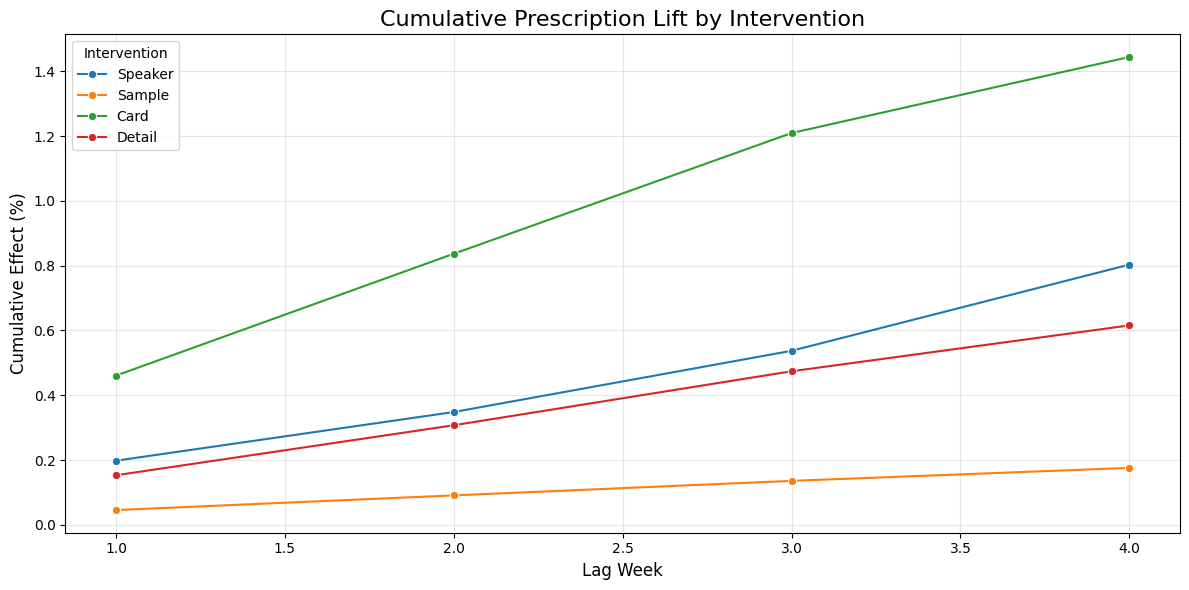

In [58]:


# Assuming `lag_model` is the regression model with parameters
df = pd.DataFrame(lag_model.params, columns=["Coefficients"]).reset_index()
df.columns = ["Variable", "Coefficients"]

# Extract lag week and intervention from 'Variable' column
df["Lag Week"] = df["Variable"].str.extract(r"_Lag_(\d+)").fillna(0).astype(int)
df["Intervention"] = df["Variable"].str.extract(r"([A-Za-z]+)(?=_Lag_)").fillna(df["Variable"])

# Filter rows to include only relevant interventions and lags
relevant_interventions = ["Speaker", "Sample", "Card", "Detail"]
df_cumulative = df[df["Intervention"].isin(relevant_interventions) & df["Lag Week"].ge(0)]

# Calculate cumulative effects
df_cumulative["Cumulative Effect"] = (
    df_cumulative.groupby("Intervention")["Coefficients"].cumsum()
)

# Melt the data for plotting
df_cumulative_melted = df_cumulative.melt(
    id_vars=["Lag Week", "Intervention"],
    value_vars=["Cumulative Effect"],
    var_name="Metric",
    value_name="Effect",
)

# Plot the cumulative effects
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_cumulative_melted,
    x="Lag Week",
    y="Effect",
    hue="Intervention",
    marker="o",
    palette="tab10",
)
plt.title("Cumulative Prescription Lift by Intervention", fontsize=16)
plt.xlabel("Lag Week", fontsize=12)
plt.ylabel("Cumulative Effect (%)", fontsize=12)
plt.legend(title="Intervention", loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [66]:
print(physician_data.columns)
physician_data.columns = physician_data.columns.str.strip()
print(physician_data.columns)



Index(['Physician ID', 'Date', 'Physician'], dtype='object')
Index(['Physician ID', 'Date', 'Physician'], dtype='object')


In [68]:
# Ensure columns are clean in physician_data
physician_data.columns = physician_data.columns.str.strip()

# Verify available columns in physician_data
print("Columns in physician_data:", physician_data.columns)

# Extract only the required columns
required_columns = ['Physician ID', 'Geography', 'Industry Decile Ranking']
if all(col in physician_data.columns for col in required_columns):
    physician_data = physician_data[required_columns]
else:
    print("Missing required columns in physician_data!")

# Merge the Physician data with the main dataset
merged_data = merged_data.merge(physician_data, on='Physician ID', how='left')

# Confirm the merge by printing the columns
print("Columns in merged_data after merge:", merged_data.columns)

# Perform segmentation analysis by Geography
if 'Geography' in merged_data.columns:
    for segment in merged_data['Geography'].dropna().unique():
        segment_data = merged_data[merged_data['Geography'] == segment]
        lag_model_segment = smf.ols(formula=formula, data=segment_data).fit()
        print(f"Results for Geography: {segment}")
        print(lag_model_segment.summary())
else:
    print("Geography column not found in merged_data!")

# Perform segmentation analysis by Industry Decile Ranking
if 'Industry Decile Ranking' in merged_data.columns:
    for decile in merged_data['Industry Decile Ranking'].dropna().unique():
        segment_data = merged_data[merged_data['Industry Decile Ranking'] == decile]
        lag_model_segment = smf.ols(formula=formula, data=segment_data).fit()
        print(f"Results for Decile: {decile}")
        print(lag_model_segment.summary())
else:
    print("Industry Decile Ranking column not found in merged_data!")


Columns in physician_data: Index(['Physician ID', 'Date', 'Physician'], dtype='object')
Missing required columns in physician_data!
Columns in merged_data after merge: Index(['Physician ID', 'Date_x', 'Prescription', 'Speaker', 'Sample', 'Card',
       'Detail', 'Speaker_Lag_1', 'Speaker_Lag_2', 'Speaker_Lag_3',
       'Speaker_Lag_4', 'Sample_Lag_1', 'Sample_Lag_2', 'Sample_Lag_3',
       'Sample_Lag_4', 'Card_Lag_1', 'Card_Lag_2', 'Card_Lag_3', 'Card_Lag_4',
       'Detail_Lag_1', 'Detail_Lag_2', 'Detail_Lag_3', 'Detail_Lag_4',
       'Date_y', 'Physician'],
      dtype='object')
Geography column not found in merged_data!
Industry Decile Ranking column not found in merged_data!


In [64]:
# Ensure the Physician sheet is correctly loaded
physician_data = processed_dataframes['Physician']

# Validate the columns in the Physician DataFrame
print(physician_data.columns)

# Merge the Physician data with the main dataset
merged_data = merged_data.merge(
    physician_data[['Physician ID', 'Geography', 'Industry Decile Ranking']],
    on='Physician ID',
    how='left'
)

# Confirm the new columns are added to the main dataset
print(merged_data.columns)

# Perform segmentation analysis by Geography
for segment in merged_data['Geography'].dropna().unique():
    segment_data = merged_data[merged_data['Geography'] == segment]
    lag_model_segment = smf.ols(formula=formula, data=segment_data).fit()
    print(f"Results for Geography: {segment}")
    print(lag_model_segment.summary())

# Perform segmentation analysis by Industry Decile Ranking
for decile in merged_data['Industry Decile Ranking'].dropna().unique():
    segment_data = merged_data[merged_data['Industry Decile Ranking'] == decile]
    lag_model_segment = smf.ols(formula=formula, data=segment_data).fit()
    print(f"Results for Decile: {decile}")
    print(lag_model_segment.summary())


Index(['Physician ID', 'Date', 'Physician'], dtype='object')


KeyError: "['Geography', 'Industry Decile Ranking'] not in index"